In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [40]:
# The CSV columns are: image_name,x1,y1,x2,y2,class,image_width,image_height
columns = ["image_name", "x1", "y1", "x2", "y2", "class_name", "image_width", "image_height"]

train_annotations = pd.read_csv('../data/SKU110K_fixed/annotations/annotations_train.csv', header=None)
train_annotations.columns = columns

test_annotations = pd.read_csv('../data/SKU110K_fixed/annotations/annotations_test.csv', header=None)
test_annotations.columns = columns

val_annotations = pd.read_csv('../data/SKU110K_fixed/annotations/annotations_val.csv', header=None)
val_annotations.columns = columns

dataset = {
    "train": train_annotations,
    "test": test_annotations,
    "val": val_annotations
}

In [41]:
train_annotations.head()

,image_name,x1,y1,x2,y2,class_name,image_width,image_height
0,train_0.jpg,208,537,422,814,object,3024,3024
1,train_0.jpg,1268,1923,1365,2209,object,3024,3024
2,train_0.jpg,1135,2074,1261,2166,object,3024,3024
3,train_0.jpg,1045,2085,1122,2258,object,3024,3024
4,train_0.jpg,976,2036,1040,2177,object,3024,3024


(array([6.55000e+02, 1.18000e+02, 6.08670e+04, 7.94870e+04, 2.40748e+05,
        5.31492e+05, 1.90140e+04, 2.55197e+05, 1.44720e+04, 6.43200e+03]),
 array([ 640. , 1107.2, 1574.4, 2041.6, 2508.8, 2976. , 3443.2, 3910.4,
        4377.6, 4844.8, 5312. ]),
 <BarContainer object of 10 artists>)

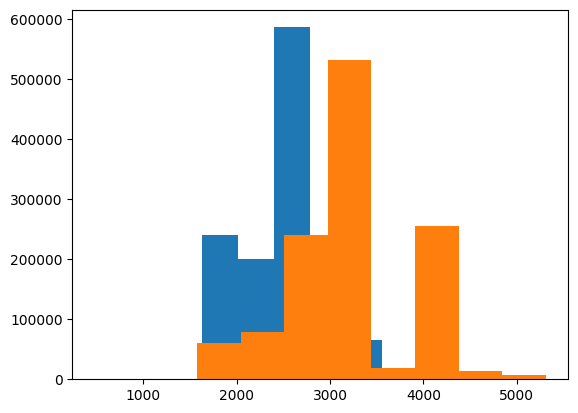

In [15]:
plt.hist(train_annotations.image_width)
plt.hist(train_annotations.image_height)

In [12]:
train_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208482 entries, 0 to 1208481
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   image_name    1208482 non-null  object
 1   x1            1208482 non-null  int64 
 2   y1            1208482 non-null  int64 
 3   x2            1208482 non-null  int64 
 4   y2            1208482 non-null  int64 
 5   class         1208482 non-null  object
 6   image_width   1208482 non-null  int64 
 7   image_height  1208482 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 73.8+ MB


In [5]:
train_annotations.object.value_counts()

object
object    1208481
Name: count, dtype: int64

In [17]:
from ultralytics import YOLO

In [21]:
model = YOLO(f'../models/yolov8n.pt')
results = model.predict(source='../data/examples/001.jpg', conf=0.25)


image 1/1 /home/denys/object-detection-supermarket/notebooks/../data/examples/001.jpg: 448x640 (no detections), 76.9ms
Speed: 2.2ms preprocess, 76.9ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


In [30]:
results[0].boxes

WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


ultralytics.engine.results.Boxes object with attributes:

boxes: tensor([], size=(0, 6))
cls: tensor([])
conf: tensor([])
data: tensor([], size=(0, 6))
id: None
is_track: False
orig_shape: (2396, 3594)
shape: torch.Size([0, 6])
xywh: tensor([], size=(0, 4))
xywhn: tensor([], size=(0, 4))
xyxy: tensor([], size=(0, 4))
xyxyn: tensor([], size=(0, 4))

In [31]:
train_annotations.head()

,image_name,x1,y1,x2,y2,class,image_width,image_height
0,train_0.jpg,208,537,422,814,object,3024,3024
1,train_0.jpg,1268,1923,1365,2209,object,3024,3024
2,train_0.jpg,1135,2074,1261,2166,object,3024,3024
3,train_0.jpg,1045,2085,1122,2258,object,3024,3024
4,train_0.jpg,976,2036,1040,2177,object,3024,3024


In [70]:
train_annotations.groupby("image_name")["image_name"].count()

image_name
train_0.jpg       141
train_1.jpg       135
train_10.jpg      156
train_100.jpg     165
train_1000.jpg     82
                 ... 
train_995.jpg     193
train_996.jpg     154
train_997.jpg     227
train_998.jpg     160
train_999.jpg     141
Name: image_name, Length: 8219, dtype: int64

In [46]:
classes = {class_name: i for i, class_name in enumerate(pd.concat([d for d in dataset.values()])["class_name"].unique())}
classes

{'object': 0}

In [77]:
import os
from pathlib import Path
import shutil
from tqdm import tqdm

def clear_directory(path: str) -> None:
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove files and symbolic links
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove subdirectories


def convert_boxes_to_yolo_format(x1: int, y1: int, x2: int, y2: int, image_width: int, image_height: int) -> str:
    """
        Converts the bounding box coordinates to yolo format

        returns: str "x_center_n y_center_n bbox_width_n bbox_height_n"
    """
    x_center = (x1 + x2) / 2
    y_center = (y1 + y2) / 2
    width = x2 - x1
    height = y2 - y1

    x_center_n = x_center / image_width
    y_center_n = y_center / image_height
    width_n = width / image_width
    height_n = height / image_height

    return f"{x_center_n} {y_center_n} {width_n} {height_n}"


def prepare_dataset(datasets: pd.DataFrame, data_path: str, images_dir: str) -> None:
    """
        datasets: dict
            {
                "train": ...,
                "test": ...,
                "val": ...
            }

        Creates this data structure

        dataset
            - images
                - train
                    - 001.jpg
                - test
                    - 001.jpg
                - val
                    - 001.jpg
            - labels
                - train
                    - 001.txt
                - test
                    - 001.txt
                - val
                    - 001.txt

        YOLO expects this format x_center_n, y_center_n bbox_width_n, bbox_height_n
    """
    data_dir = Path(data_path)
    images_dir = Path(images_dir)

    if os.path.exists(data_dir):
        shutil.rmtree(data_dir)
    for split in datasets:
        os.makedirs(data_dir / f"images/{split}", exist_ok=True)
        os.makedirs(data_dir / f"labels/{split}", exist_ok=True)

    classes = {class_name: i for i, class_name in enumerate(pd.concat([d for d in dataset.values()])["class_name"].unique())}
    for split in datasets:
        for _, image in tqdm(datasets[split].groupby("image_name")):
            image_name =  image["image_name"].values[0]
            image_fpath = images_dir / image_name
            new_image_fpath = data_dir / "images" / split /  image_name
            label_fpath = data_dir / "labels" / split / image_name.replace(".jpg", ".txt").replace(".png", ".txt")

            if not os.path.exists(new_image_fpath):
                shutil.copy(image_fpath, new_image_fpath)
            
            with open(label_fpath, "w"):
                pass
            

            for _, box in image.iterrows(): 
                with open(label_fpath, "a") as f:
                    f.write(f"{classes[box['class_name']]} " + convert_boxes_to_yolo_format(box.x1, box.y1, box.x2, box.y2, box.image_width, box.image_height) + "\n")

In [78]:
prepare_dataset(dataset, "../data/dataset", "../data/SKU110K_fixed/images")

  7%|▋         | 541/8219 [00:12<03:33, 36.04it/s]